# TSEvo

A counterfactual explanation, originally introduced to machine learning by [2], answers the question "what if" by building counterexamples. Based on an input instance $x$, the goal is to find a counterfactual $x^{cf}$ close to the original instance $x$ but differently classified $y \neq y^{cf}$ by a predictor $f$. The intention is to visualize boundary cases. Further research has shown that counterfactual explanations are easy to understand for humans because they are intuitive  to human thinking by showing counterexamples.  

<img src="https://fzi-forschungszentrum-informatik.github.io/TSInterpret/Notebooks/TSEvo.png" alt="Visualization of TSEvo" style="width: 800px;"/>

TSEvo [1] adapts the notion of counterfactual to the domain of uni- and multivariate time series classification by building and optimizing a Problem consisting of notions for proximity ($R_{1}$), sparsity ($R_{2}$) and the output distance ($R_{4}$). The optimization problem is solved by applying an evolutionary algorithm based on NSGA-II with mutation operators ($R_{3}$) adapted to the time series domain.


[1] Jacqueline Höllig, Cedric Kulbach and Steffen Thoma. TSEvo: Evolutionary Counterfactual Explanations for Time Series Classification. 2022 International Conference on Machine Learning and Applications (ICMLA).

[2] Wachter, Sandra, Brent Mittelstadt, and Chris Russell. "Counterfactual explanations without opening the black box: Automated decisions and the GDPR." Harv. JL & Tech. 31 (2017): 841.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pandas as pd
import numpy as np
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
from sklearn import tree
from sklearn.model_selection import cross_val_score
from pymop import Problem
import os
from tslearn.datasets import UCR_UEA_datasets
import warnings
warnings.filterwarnings('ignore')
import pickle


## Load Data

In [2]:
dataset='ECG5000'
X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2])
enc1=pickle.load(open(f'../../ClassificationModels//models/{dataset}/OneHotEncoder.pkl','rb'))
test_y=enc1.transform(test_y.reshape(-1,1))
n_classes = test_y.shape[1]


## Load Pretrained Model

In [3]:
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset, get_all_preds
stride = 1
kernel_size=10
padding = kernel_size - 1
input_size= train_x.shape[-1]
device = torch.device( "cpu")#"cuda:0" if torch.cuda.is_available() else
model = ResNetBaseline(in_channels= 1, num_pred_classes=2)
model.load_state_dict(torch.load(f'../../ClassificationModels/models/GunPoint/ResNet'))
test_dataset = UCRDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)


In [4]:
model.eval()
y_pred,labels= get_all_preds(model,test_loader)

In [5]:
observation_01, label_01 = test_dataset[0]
label_01=np.array([y_pred[0]])
print(observation_01.shape)
print(label_01.shape)


(1, 140)
(1,)


## Interpretability Algorithm
Using a interpretability algorithm consists of 4 steps:

1. Load the Interpretability Method
2. Instaniate the Method with the desired Parameters
3. Call the explain Method
4. Plot the results
### 1. & 2. Loading & Initialization

    `model`: The model to be explaines.
    `data`: Tuple of Data and Labels.
    `backend`: `PYT`, `SK`, or `TF`.
    `mode`: second dimension is either `feat` or `time`. 

In [6]:
from TSInterpret.InterpretabilityModels.counterfactual.TSEvoCF import TSEvo
exp =TSEvo(model= model,data=(test_x,np.array(y_pred)), mode = 'feat',backend='PYT',epochs =500)

<class 'numpy.int64'>


### 3. Call the explain method.

Prepeare the instance and the predicted label of the instance as parameters for the explain methods.

- `item`: item to be explained
- `method`: ['authentic_opposing','mutate_both','gaussian','frequency']
- `target_y`: targeted CF class, can be None
- `epochs`: # iterations

In [7]:
pop,label_cf=exp.explain(observation_01.reshape(1,1,-1),np.array(label_01))

1
(1, 1, 140)
No Target


### 4. Visualization

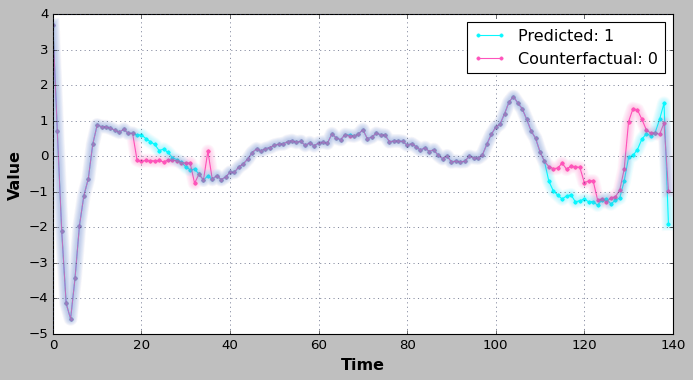

In [8]:
exp.plot_in_one(observation_01,label_01[0],pop,np.argmax(label_cf),save_fig=None)